In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix
from xgboost import XGBClassifier
from wordcloud import WordCloud

In [3]:
# Load the data
train = pd.read_csv('train.csv', encoding='latin-1')
test = pd.read_csv('test.csv', encoding='latin-1')

print(train.shape)
print(test.shape)

(120, 2)
(50, 2)


In [4]:
# Display the first few rows of the datasets
print(train.head())
print(test.head())

                                              tweets  Sentiment
0  Well done Dedan Kimathi University. Your coffe...          1
1  Dedan Kimathi University unveils machine power...          1
2  Dedan Kimathi University, Nyeri county grows a...          1
3  Bad weather could allow mwe go get the dekut c...         -1
4  Local Premium coffee from Dedan Kimathi Univer...          1
                                              tweets  Sentiment
0  freezing!!  drinking coffee at Dedan Kimathi ...          1
1  Over 20 coffee buyers from the United Arab Emi...         -1
2  During the official Launch of Natural Extract ...          0
3  TOMORROW, Coffee Expo will be held at Dedan Ki...          0
4            I did not like the dekut coffee youghut         -1


In [5]:
# Check for missing values
print(train.isnull().any())
print(test.isnull().any())

tweets       False
Sentiment    False
dtype: bool
tweets       False
Sentiment    False
dtype: bool


In [6]:
# Checking out the negative and positive comments from the train set
print(train[train['Sentiment'] == -1].head(10))
print(train[train['Sentiment'] == 1].head(10))

                                                tweets  Sentiment
3    Bad weather could allow mwe go get the dekut c...         -1
10   Over 20 coffee buyers from the United Arab Emi...         -1
13             I did not like the dekut coffee youghut         -1
22   I prefer to buy roasted beans and grind them w...         -1
53                                 I hate coffee a lot         -1
64   Its realy hard to find dekut youghut in the ma...         -1
106  Just bought some Brookside yogurt. It's alrigh...         -1
116  I had a bad experience with dekut yought. It t...         -1
                                               tweets  Sentiment
0   Well done Dedan Kimathi University. Your coffe...          1
1   Dedan Kimathi University unveils machine power...          1
2   Dedan Kimathi University, Nyeri county grows a...          1
4   Local Premium coffee from Dedan Kimathi Univer...          1
7   On a chilly day here at Mount Kenya region, co...          1
9   freezing!! 

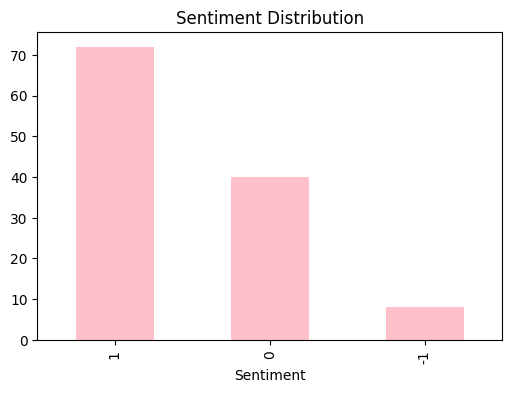

In [7]:
# Sentiment distribution
train['Sentiment'].value_counts().plot.bar(color='pink', figsize=(6, 4))
plt.title('Sentiment Distribution')
plt.show()

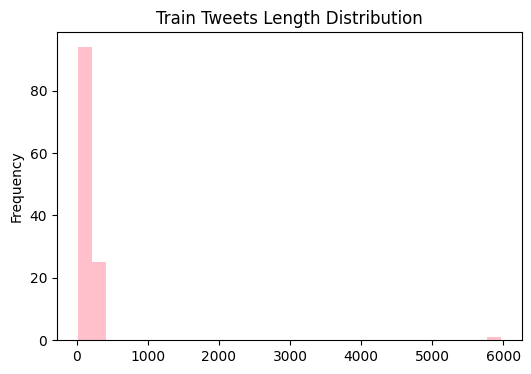

In [8]:
# Distribution of tweet lengths
train['tweets'].str.len().plot.hist(color='pink', figsize=(6, 4), bins=30)
plt.title('Train Tweets Length Distribution')
plt.show()

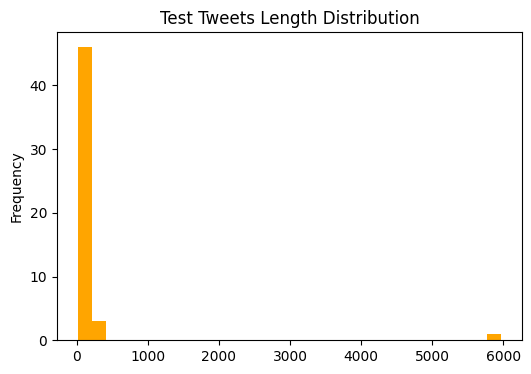

In [9]:
test['tweets'].str.len().plot.hist(color='orange', figsize=(6, 4), bins=30)
plt.title('Test Tweets Length Distribution')
plt.show()

In [10]:
# Adding a column to represent the length of the tweet
train['len'] = train['tweets'].str.len()
test['len'] = test['tweets'].str.len()

print(train.head(10))

                                              tweets  Sentiment  len
0  Well done Dedan Kimathi University. Your coffe...          1   61
1  Dedan Kimathi University unveils machine power...          1  120
2  Dedan Kimathi University, Nyeri county grows a...          1  112
3  Bad weather could allow mwe go get the dekut c...         -1   56
4  Local Premium coffee from Dedan Kimathi Univer...          1   66
5  Nyeri International Coffee Expo that is being ...          0  124
6  edan Kimathi university to oversee coffee mill...          0   77
7  On a chilly day here at Mount Kenya region, co...          1   89
8  Dedan Kimathi University of Technology Coffee ...          0   85
9  freezing!!  drinking coffee at Dedan Kimathi ...          1   71


In [11]:
# Grouping and describing by sentiment
print(train.groupby('Sentiment').describe())


            len                                                            
          count        mean         std   min    25%    50%     75%     max
Sentiment                                                                  
-1          8.0   77.875000   63.550739  19.0  51.75   59.0   74.25   224.0
 0         40.0  276.350000  924.673152  45.0  83.25  102.0  199.00  5964.0
 1         72.0  139.527778   75.945676  35.0  78.75  113.0  218.25   280.0


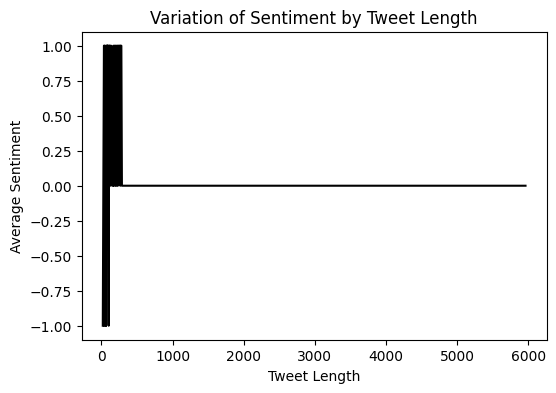

In [13]:
# Convert 'Sentiment' column to numeric
train['Sentiment'] = pd.to_numeric(train['Sentiment'], errors='coerce')

# Calculate the mean sentiment for each tweet length
length_sentiment = train.groupby('len')['Sentiment'].mean()

# Plotting the variation of tweet length by sentiment
length_sentiment.plot(color='black', figsize=(6, 4))
plt.title('Variation of Sentiment by Tweet Length')
plt.xlabel('Tweet Length')
plt.ylabel('Average Sentiment')
plt.show()

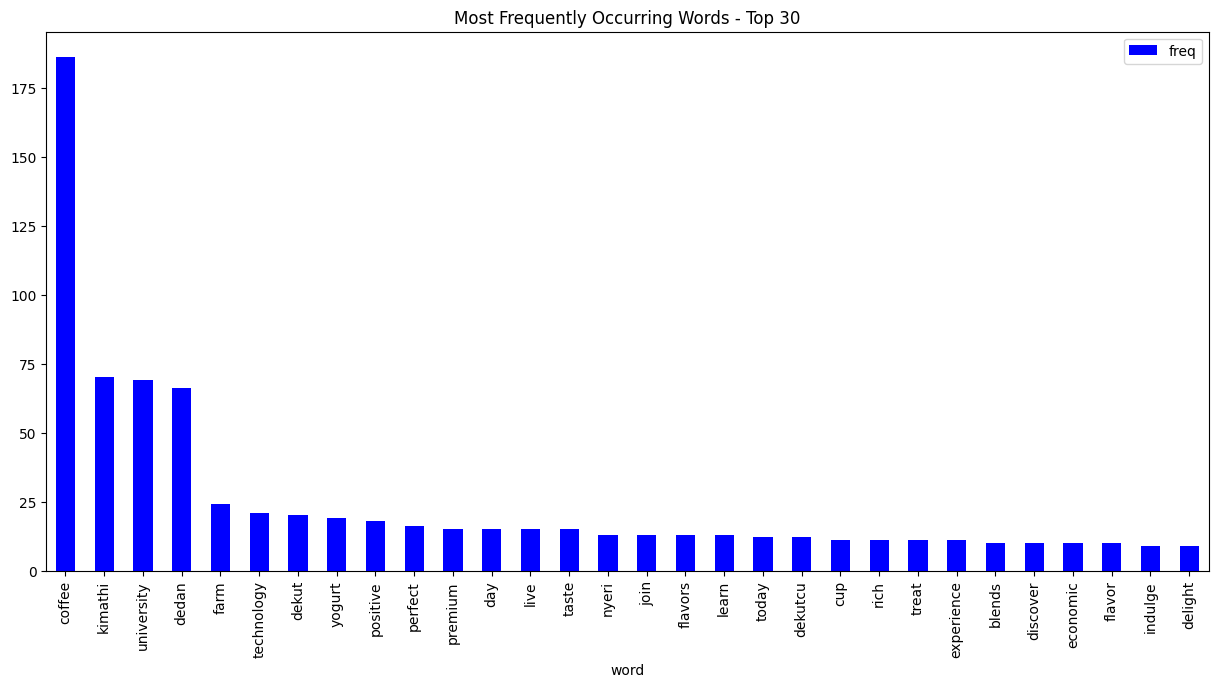

In [14]:
# Word frequency analysis
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(train['tweets'])

sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color='blue')
plt.title("Most Frequently Occurring Words - Top 30")
plt.show()

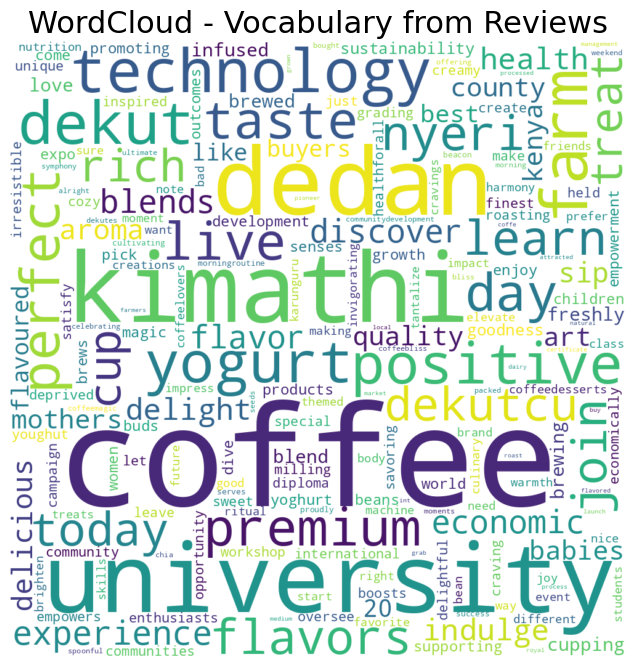

In [15]:
# Wordcloud
wordcloud = WordCloud(background_color='white', width=1000, height=1000).generate_from_frequencies(dict(words_freq))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - Vocabulary from Reviews", fontsize=22)
plt.show()

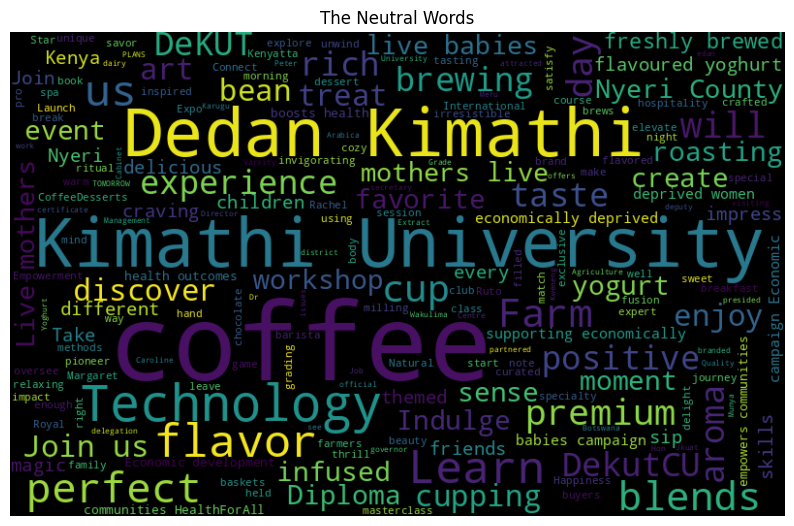

In [16]:
# Wordcloud for neutral, negative, and positive words
neutral_words = ' '.join([text for text in train['tweets'][train['Sentiment'] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=0, max_font_size=110).generate(neutral_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('The Neutral Words')
plt.show()

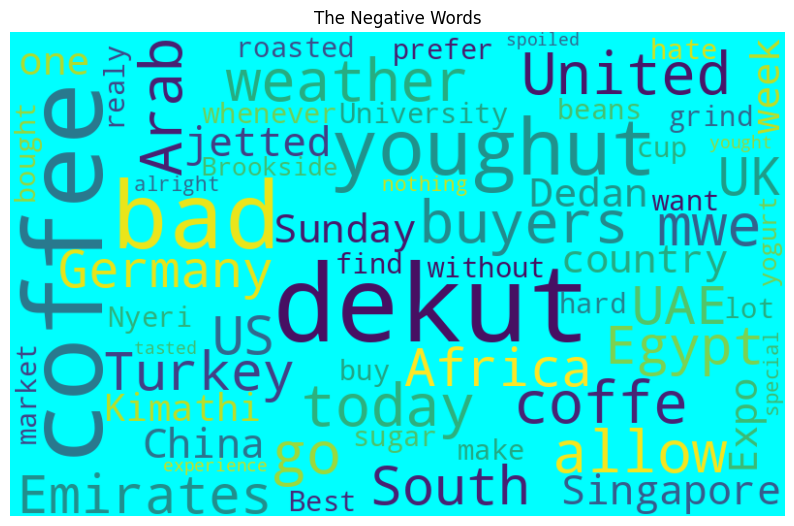

In [17]:
negative_words = ' '.join([text for text in train['tweets'][train['Sentiment'] == -1]])
wordcloud = WordCloud(background_color='cyan', width=800, height=500, random_state=0, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('The Negative Words')
plt.show()

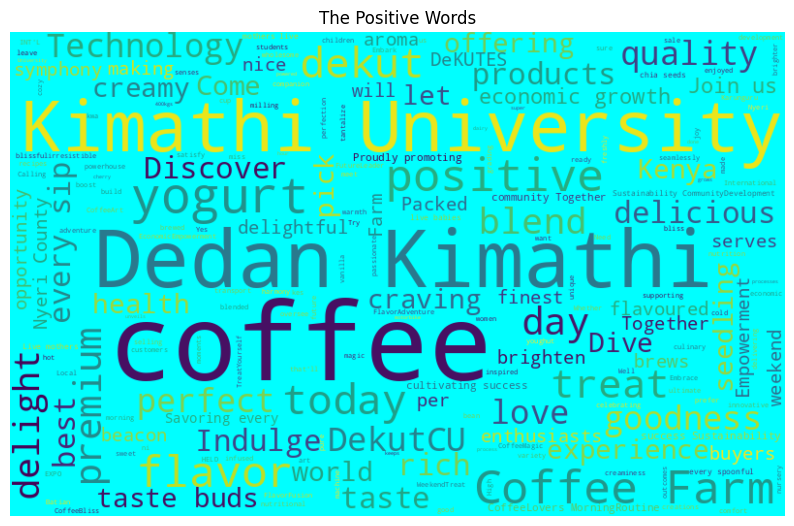

In [18]:
positive_words = ' '.join([text for text in train['tweets'][train['Sentiment'] == 1]])
wordcloud = WordCloud(background_color='cyan', width=800, height=500, random_state=0, max_font_size=110).generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('The Positive Words')
plt.show()

In [19]:
# Collecting the hashtags
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

# Extracting hashtags from different sentiments
HT_neutral = sum(hashtag_extract(train['tweets'][train['Sentiment'] == 0]), [])
HT_negative = sum(hashtag_extract(train['tweets'][train['Sentiment'] == -1]), [])
HT_positive = sum(hashtag_extract(train['tweets'][train['Sentiment'] == 1]), [])

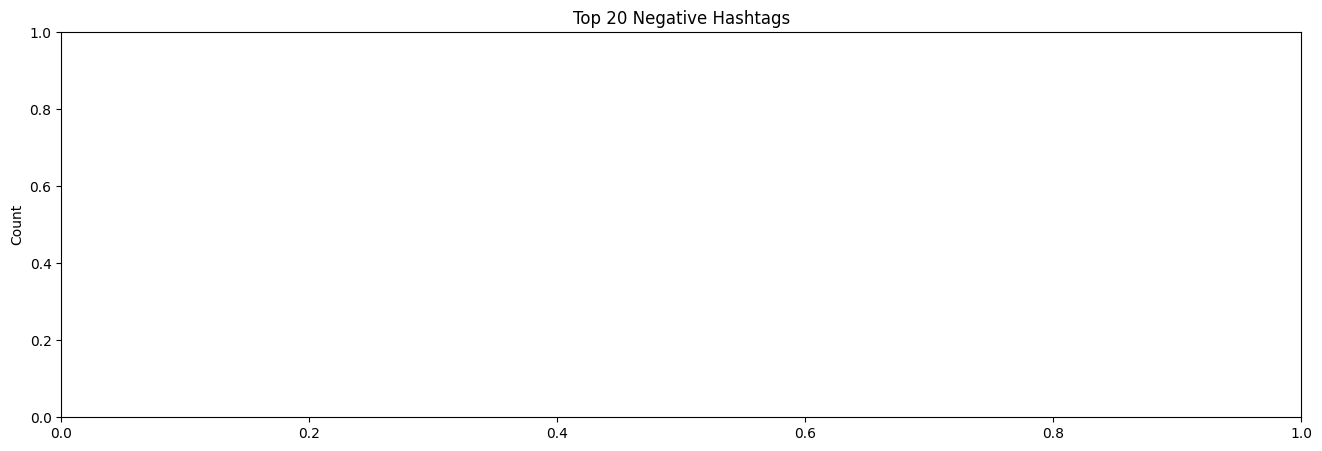

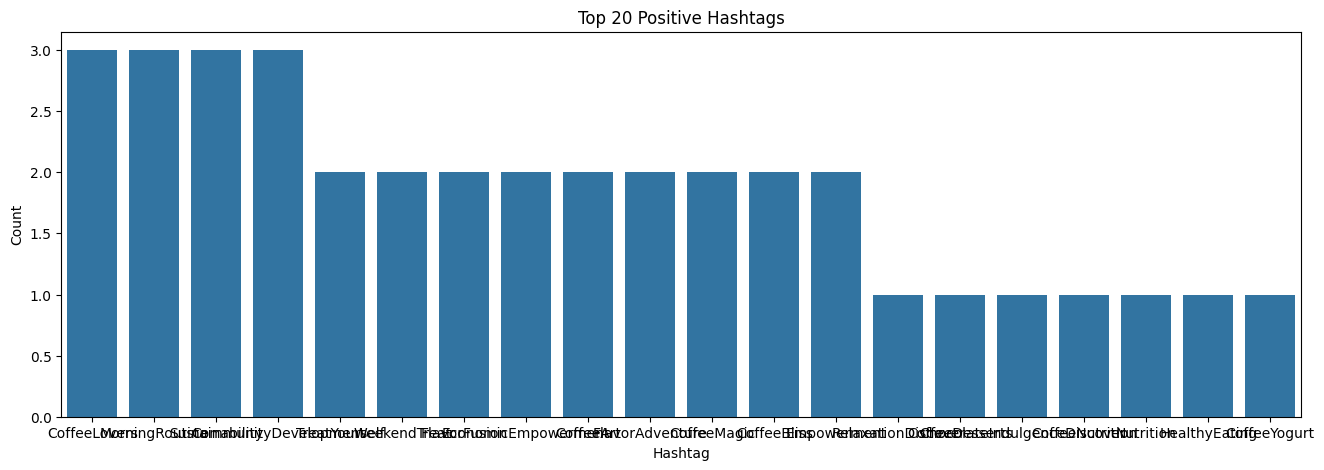

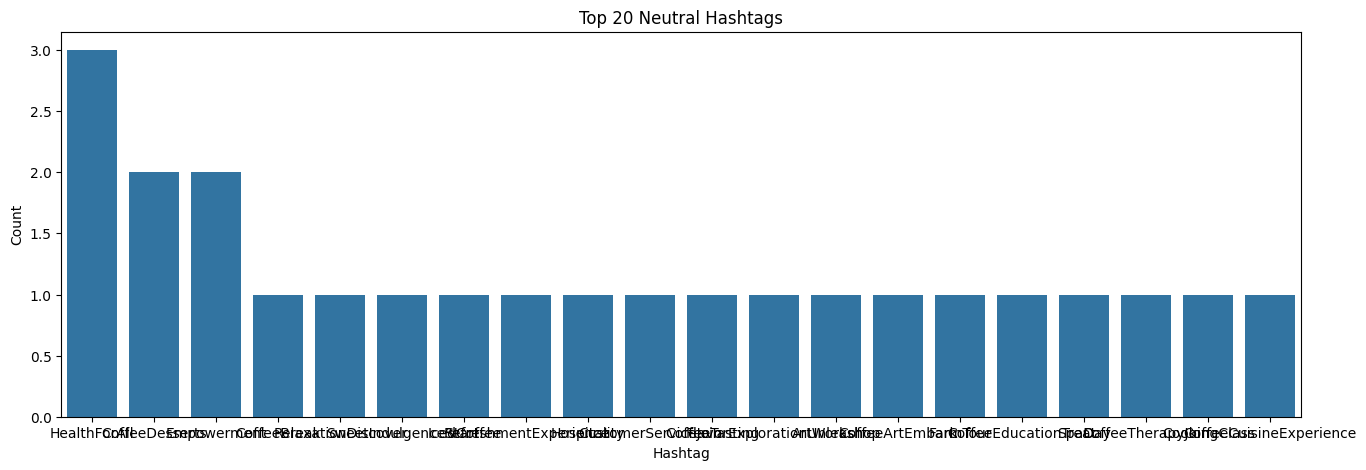

In [22]:
# Plotting top 20 hashtags for each sentiment
def plot_top_hashtags(hashtags, title):
    a = nltk.FreqDist(hashtags)
    d = pd.DataFrame({'Hashtag': list(a.keys()), 'Count': list(a.values())})
    d = d.nlargest(columns="Count", n=20)
    plt.figure(figsize=(16, 5))
    ax = sns.barplot(data=d, x="Hashtag", y="Count")
    ax.set(ylabel='Count')
    plt.title(title)
    plt.show()

plot_top_hashtags(HT_negative, 'Top 20 Negative Hashtags')
plot_top_hashtags(HT_positive, 'Top 20 Positive Hashtags')
plot_top_hashtags(HT_neutral, 'Top 20 Neutral Hashtags')

In [23]:
# Gensim - Word2Vec
from gensim.models import Word2Vec

# Tokenization function for Word2Vec
def tokenize_tweets(tweets):
    tokenized_tweet = tweets.apply(lambda x: x.split())
    return tokenized_tweet

tokenized_tweet = tokenize_tweets(train['tweets'])

In [24]:
# Creating a Word2Vec model
model_w2v = Word2Vec(
    tokenized_tweet,
    vector_size=200,  # Desired number of features/independent variables
    window=5,         # Context window size
    min_count=2,
    sg=1,             # 1 for skip-gram model
    hs=0,
    negative=10,      # For negative sampling
    workers=2,        # Number of cores
    seed=34
)

model_w2v.train(tokenized_tweet, total_examples=len(train['tweets']), epochs=20)

# Display most similar words
print(model_w2v.wv.most_similar(positive="coffee"))
print(model_w2v.wv.most_similar(positive="nice"))
print(model_w2v.wv.most_similar(positive="like"))
print(model_w2v.wv.most_similar(negative="don't"))

[('different', 0.981756329536438), ('methods', 0.9811151623725891), ('workshop.', 0.9808704853057861), ('create', 0.9801613688468933), ('to', 0.9800209999084473), ('discover', 0.9790138006210327), ('experience', 0.9779331684112549), ('unique', 0.9776846170425415), ('day', 0.9775347113609314), ('right', 0.9766795039176941)]
[('enjoyed', 0.9988210797309875), ('preferred', 0.9956813454627991), ('facilities', 0.9951644539833069), ('back', 0.9944736957550049), ('Kenyatta', 0.9943615198135376), ('Margaret', 0.99433434009552), ('bad', 0.9942253828048706), ('market', 0.9941532611846924), ('I', 0.9939603805541992), ('had', 0.9939217567443848)]
[('youghut', 0.9806193709373474), ('Babies', 0.9749453067779541), ('preferred', 0.9734222888946533), ('impact', 0.972334086894989), ('Join', 0.972163200378418), ('well-being.', 0.970199704170227), ('nice', 0.9698020815849304), ('#ChocolateIndulgenceDiscover', 0.9696561694145203), ('#CoffeeNutrition', 0.9695979356765747), ('benefits', 0.9680089354515076)]


In [25]:
# Labeling tweets for Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm

tqdm.pandas(desc="progress-bar")

def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(TaggedDocument(s, ["tweet_" + str(i)]))
    return output

labeled_tweets = add_label(tokenized_tweet)
print(labeled_tweets[:6])

[TaggedDocument(words=['Well', 'done', 'Dedan', 'Kimathi', 'University.', 'Your', 'coffee', 'is', 'super!!', '??'], tags=['tweet_0']), TaggedDocument(words=['Dedan', 'Kimathi', 'University', 'unveils', 'machine', 'powered', 'by', 'a', 'motorbike.', 'The', 'machine', 'can', 'process', 'up', 'to', '400kgs', 'of', 'cherry', 'per', 'hour'], tags=['tweet_1']), TaggedDocument(words=['Dedan', 'Kimathi', 'University,', 'Nyeri', 'county', 'grows', 'and', 'processes', 'some', 'of', 'the', 'best', 'coffee', 'and', 'dairy', 'products', 'in', 'Kenya.'], tags=['tweet_2']), TaggedDocument(words=['Bad', 'weather', 'could', 'allow', 'mwe', 'go', 'get', 'the', 'dekut', 'coffe', 'today'], tags=['tweet_3']), TaggedDocument(words=['Local', 'Premium', 'coffee', 'from', 'Dedan', 'Kimathi', 'University', 'keeps', 'me', 'going'], tags=['tweet_4']), TaggedDocument(words=['Nyeri', 'International', 'Coffee', 'Expo', 'that', 'is', 'being', 'held', 'at', 'Dedan', 'Kimathi', 'University', 'has', 'attracted', '20', '

In [26]:
# Removing unwanted patterns and stopwords, and stemming the tweets
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

def preprocess_tweets(tweets):
    corpus = []
    ps = PorterStemmer()
    for i in range(len(tweets)):
        review = re.sub('[^a-zA-Z]', ' ', tweets[i])
        review = review.lower()
        review = review.split()
        review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
        review = ' '.join(review)
        corpus.append(review)
    return corpus

train_corpus = preprocess_tweets(train['tweets'])
test_corpus = preprocess_tweets(test['tweets'])

# Creating bag of words
cv = CountVectorizer(max_features=2500)
x = cv.fit_transform(train_corpus).toarray()
y = train['Sentiment']

print(x.shape)
print(y.shape)

x_test = cv.transform(test_corpus).toarray()
print(x_test.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


(120, 662)
(120,)
(50, 662)


In [27]:
# Splitting the training data into train and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, random_state=42)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(90, 662)
(30, 662)
(90,)
(30,)


In [28]:
# Model training and evaluation function
def train_and_evaluate_model(model, x_train, y_train, x_valid, y_valid):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_valid)
    train_accuracy = model.score(x_train, y_train)
    valid_accuracy = model.score(x_valid, y_valid)
    f1 = f1_score(y_valid, y_pred, average='weighted')
    cm = confusion_matrix(y_valid, y_pred)
    return train_accuracy, valid_accuracy, f1, cm

# Logistic Regression
model_lr = LogisticRegression(max_iter=1000)
train_acc_lr, valid_acc_lr, f1_lr, cm_lr = train_and_evaluate_model(model_lr, x_train, y_train, x_valid, y_valid)
print("Logistic Regression - Training Accuracy:", train_acc_lr)
print("Logistic Regression - Validation Accuracy:", valid_acc_lr)
print("Logistic Regression - F1 Score:", f1_lr)
print("Logistic Regression - Confusion Matrix:\n", cm_lr)

Logistic Regression - Training Accuracy: 0.9555555555555556
Logistic Regression - Validation Accuracy: 0.4666666666666667
Logistic Regression - F1 Score: 0.4128654970760233
Logistic Regression - Confusion Matrix:
 [[ 1  0  1]
 [ 0  2 12]
 [ 0  3 11]]


In [29]:
# Decision Tree Classifier
model_dt = DecisionTreeClassifier()
train_acc_dt, valid_acc_dt, f1_dt, cm_dt = train_and_evaluate_model(model_dt, x_train, y_train, x_valid, y_valid)
print("Decision Tree - Training Accuracy:", train_acc_dt)
print("Decision Tree - Validation Accuracy:", valid_acc_dt)
print("Decision Tree - F1 Score:", f1_dt)
print("Decision Tree - Confusion Matrix:\n", cm_dt)

Decision Tree - Training Accuracy: 0.9666666666666667
Decision Tree - Validation Accuracy: 0.5
Decision Tree - F1 Score: 0.4353276353276353
Decision Tree - Confusion Matrix:
 [[ 1  0  1]
 [ 0  2 12]
 [ 0  2 12]]


In [30]:
# Support Vector Machine
model_svm = SVC()
train_acc_svm, valid_acc_svm, f1_svm, cm_svm = train_and_evaluate_model(model_svm, x_train, y_train, x_valid, y_valid)
print("SVM - Training Accuracy:", train_acc_svm)
print("SVM - Validation Accuracy:", valid_acc_svm)
print("SVM - F1 Score:", f1_svm)
print("SVM - Confusion Matrix:\n", cm_svm)

SVM - Training Accuracy: 0.6777777777777778
SVM - Validation Accuracy: 0.4666666666666667
SVM - F1 Score: 0.29696969696969694
SVM - Confusion Matrix:
 [[ 0  0  2]
 [ 0  0 14]
 [ 0  0 14]]


In [31]:
# XGBoost Classifier
class_mapping = {-1: 0, 0: 1, 1: 2}
y_train_mapped = np.array([class_mapping[label] for label in y_train])
y_valid_mapped = np.array([class_mapping[label] for label in y_valid])

model_xgb = XGBClassifier()
model_xgb.fit(x_train, y_train_mapped)
y_pred_xgb = model_xgb.predict(x_valid)

train_acc_xgb = model_xgb.score(x_train, y_train_mapped)
valid_acc_xgb = model_xgb.score(x_valid, y_valid_mapped)
f1_xgb = f1_score(y_valid_mapped, y_pred_xgb, average='weighted')
cm_xgb = confusion_matrix(y_valid_mapped, y_pred_xgb)

print("XGBoost - Training Accuracy:", train_acc_xgb)
print("XGBoost - Validation Accuracy:", valid_acc_xgb)
print("XGBoost - F1 Score:", f1_xgb)
print("XGBoost - Confusion Matrix:\n", cm_xgb)

XGBoost - Training Accuracy: 0.9444444444444444
XGBoost - Validation Accuracy: 0.43333333333333335
XGBoost - F1 Score: 0.3785185185185186
XGBoost - Confusion Matrix:
 [[ 0  1  1]
 [ 2  2 10]
 [ 0  3 11]]


In [34]:
pip install transformers torch -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 49.1 MB/s eta 0:00:00


In [35]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the tokenizer and model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [36]:
def predict_sentiment(text, tokenizer, model):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # Perform inference
    outputs = model(**inputs)
    # Get the predicted class (0: Negative, 1: Neutral, 2: Positive)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()
    return predicted_class - 1  # Adjust to match -1, 0, 1 sentiment labels

# Apply the sentiment prediction function to the tweets in the training and testing datasets
train['Predicted_Sentiment'] = train['tweets'].apply(lambda x: predict_sentiment(x, tokenizer, model))
test['Predicted_Sentiment'] = test['tweets'].apply(lambda x: predict_sentiment(x, tokenizer, model))

In [37]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Calculate performance metrics for the training data
train_accuracy = accuracy_score(train['Sentiment'], train['Predicted_Sentiment'])
train_f1 = f1_score(train['Sentiment'], train['Predicted_Sentiment'], average='weighted')
train_cm = confusion_matrix(train['Sentiment'], train['Predicted_Sentiment'])

print("Training Accuracy:", train_accuracy)
print("Training F1 Score:", train_f1)
print("Training Confusion Matrix:\n", train_cm)

# Calculate performance metrics for the testing data
test_accuracy = accuracy_score(test['Sentiment'], test['Predicted_Sentiment'])
test_f1 = f1_score(test['Sentiment'], test['Predicted_Sentiment'], average='weighted')
test_cm = confusion_matrix(test['Sentiment'], test['Predicted_Sentiment'])

print("Testing Accuracy:", test_accuracy)
print("Testing F1 Score:", test_f1)
print("Testing Confusion Matrix:\n", test_cm)

Training Accuracy: 0.675
Training F1 Score: 0.6774349833173363
Training Confusion Matrix:
 [[ 4  2  2]
 [ 0 24 16]
 [ 0 19 53]]
Testing Accuracy: 0.66
Testing F1 Score: 0.6619047619047618
Testing Confusion Matrix:
 [[ 3  1  0]
 [ 0 17  8]
 [ 0  8 13]]


In [38]:
# Predict sentiment on validation data using the pre-trained model
valid_preds = test['tweets'].apply(lambda x: predict_sentiment(x, tokenizer, model))

# Calculate performance metrics for the validation data
valid_accuracy_pretrained = accuracy_score(test['Sentiment'], valid_preds)
f1_pretrained = f1_score(test['Sentiment'], valid_preds, average='weighted')

print("Pre-trained Model Validation Accuracy:", valid_accuracy_pretrained)
print("Pre-trained Model F1 Score:", f1_pretrained)

Pre-trained Model Validation Accuracy: 0.66
Pre-trained Model F1 Score: 0.6619047619047618


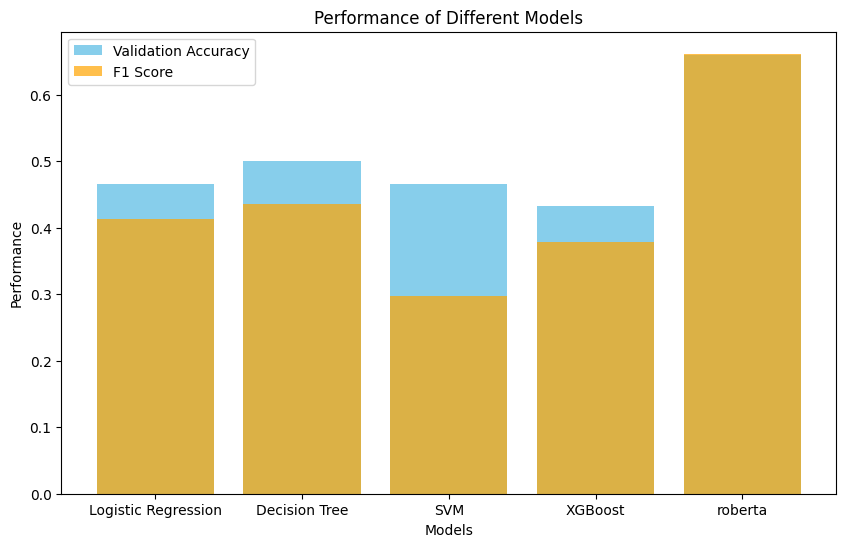

In [41]:
# Existing models' performance metrics
models = ['Logistic Regression', 'Decision Tree', 'SVM', 'XGBoost', 'roberta']
valid_accuracies = [valid_acc_lr, valid_acc_dt, valid_acc_svm, valid_acc_xgb, valid_accuracy_pretrained]
f1_scores = [f1_lr, f1_dt, f1_svm, f1_xgb, f1_pretrained]

# Plotting Validation Accuracy and F1 Score as Bar Charts
plt.figure(figsize=(10, 6))
plt.bar(models, valid_accuracies, color='skyblue', label='Validation Accuracy')
plt.bar(models, f1_scores, color='orange', alpha=0.7, label='F1 Score')
plt.xlabel('Models')
plt.ylabel('Performance')
plt.title('Performance of Different Models')
plt.legend()
plt.show()

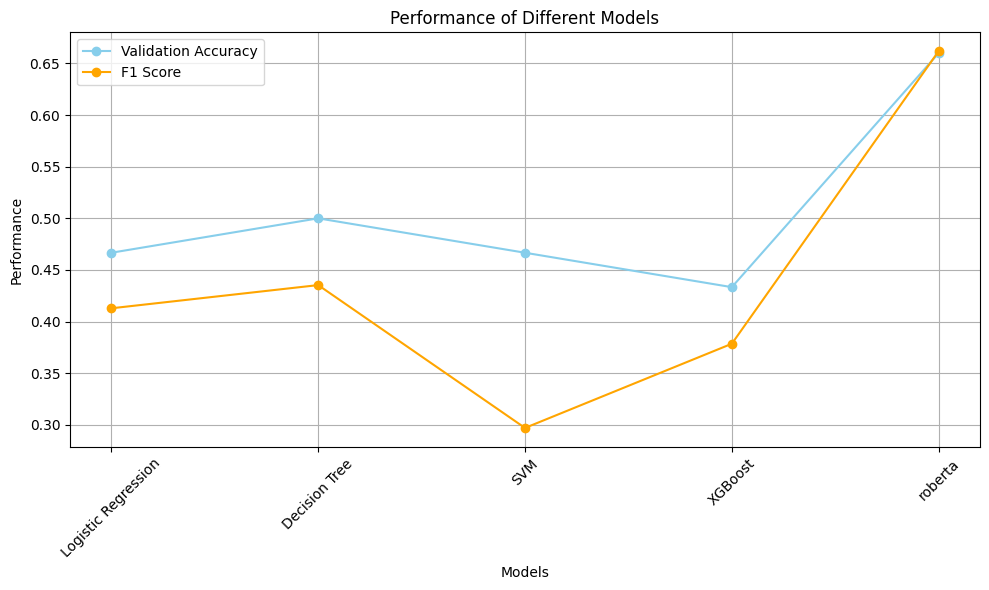

In [42]:
# Plotting Validation Accuracy and F1 Score as Line Charts
plt.figure(figsize=(10, 6))
plt.plot(models, valid_accuracies, marker='o', label='Validation Accuracy', color='skyblue')
plt.plot(models, f1_scores, marker='o', label='F1 Score', color='orange')
plt.xlabel('Models')
plt.ylabel('Performance')
plt.title('Performance of Different Models')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()